In [1]:
!pip3 install -r requirements.txt --quiet

In [22]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 5)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.size'] = 14

In [3]:
print("Pandas Version :", pd.__version__)
print("Sqlite3 Version :", sqlite3.version)
print("Numpy Version :", np.__version__)

Pandas Version : 2.2.3
Sqlite3 Version : 2.6.0
Numpy Version : 1.26.4


In [4]:
FILE_PATH = 'https://raw.githubusercontent.com/dakshbhatnagar/Datasets/refs/heads/main/customer_churn/Churn_Modelling.csv'
df = pd.read_csv(FILE_PATH)
df = df.drop(columns=['RowNumber'])
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
n_rows, n_cols = df.shape
print(f"There are {n_rows:,} rows and {n_cols} columns in the dataset.")

There are 10,000 rows and 13 columns in the dataset.


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [9]:
df.describe().T.apply(lambda x : round(x,2)).iloc[1:,1:]

,mean,std,min,25%,50%,75%,max
CreditScore,650.53,96.65,350.00,584.00,652.00,718.00,850.00
Age,38.92,10.49,18.00,32.00,37.00,44.00,92.00
Tenure,5.01,2.89,0.00,3.00,5.00,7.00,10.00
Balance,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09
NumOfProducts,1.53,0.58,1.00,1.00,1.00,2.00,4.00
HasCrCard,0.71,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,0.52,0.50,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,100090.24,57510.49,11.58,51002.11,100193.92,149388.25,199992.48
Exited,0.20,0.40,0.00,0.00,0.00,0.00,1.00


**QUESTIONS TO DEFINITELY LOOK AT**

- Age : 18 and 92 how long are these guys associated? What's his bank balance
- Does a guy with a zero tenure have credit card, if yes, what's his credit score, bank balance and Salary and what's his age
- Are we giving out credit cards to folks with zero balance?
- Does Number of Products have any relation with the exiting?
- Active Members tend to leave more or the non active members?

In [10]:
def creditcategory(score):
  if score>= 300 and score<=499:
    return 'Poor'
  elif score>= 500 and score<=649:
    return 'Average'
  elif score>= 650 and score<=749:
    return 'Good'
  elif score>= 750 and score<=900:
    return 'Excellent'

df['CreditScoreCat'] = df['CreditScore'].apply(creditcategory)

In [11]:
conn = sqlite3.connect('churn.db')
df.to_sql('churn_data', conn, if_exists='replace', index=False)

10000

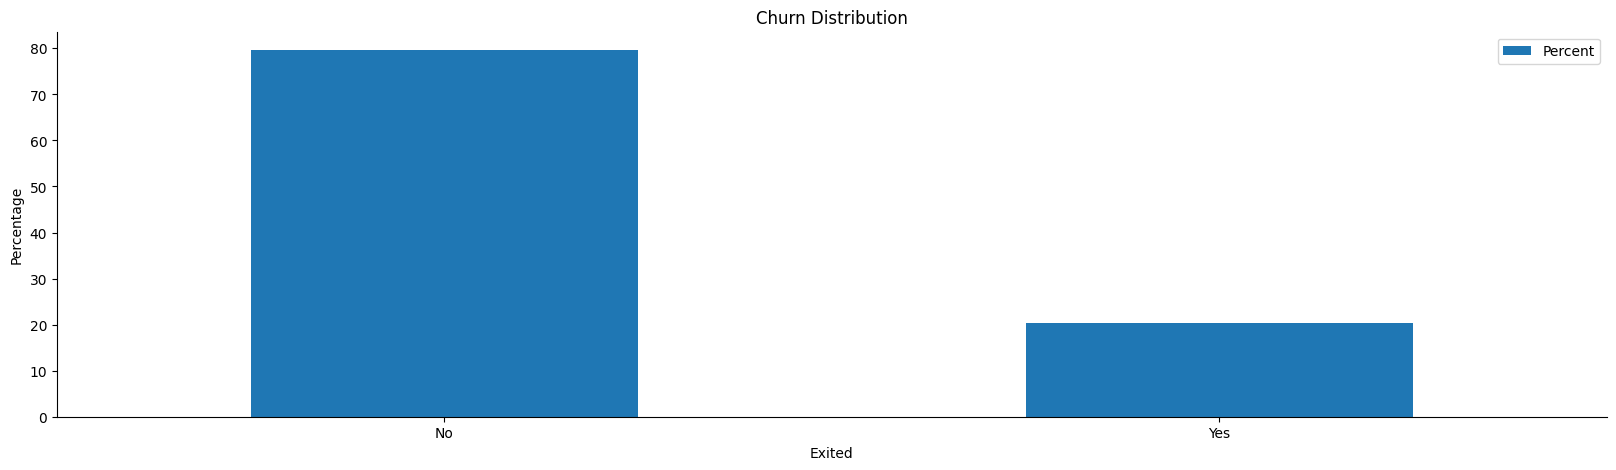

In [12]:
exited_df = (df['Exited'].value_counts()/len(df)*100).to_frame()
exited_df.plot(kind='bar')
plt.title('Churn Distribution')
plt.xticks(ticks=[0,1], labels = ['No', 'Yes'], rotation=0)
plt.ylabel('Percentage')
plt.legend(['Percent'])
plt.show()

- Observation:
There is a significant class imbalance in the dataset, which could lead to biased predictions in machine learning models favoring one class over the other.

- So What?
This imbalance may affect the model’s ability to accurately predict churn, as it might overlook the minority class (churned customers) due to its smaller representation in the data.

- Action:
While our current focus is on analyzing churned customers, we must be aware of this imbalance when developing machine learning models. Strategies such as resampling techniques (oversampling the minority class or undersampling the majority class) or using algorithms that handle class imbalance effectively should be considered in future modeling efforts.

In [13]:
churned = df[df['Exited']==1]
churned.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScoreCat
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Average
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Average
5,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,Average
7,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,Poor
16,15737452,Romeo,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1,Good


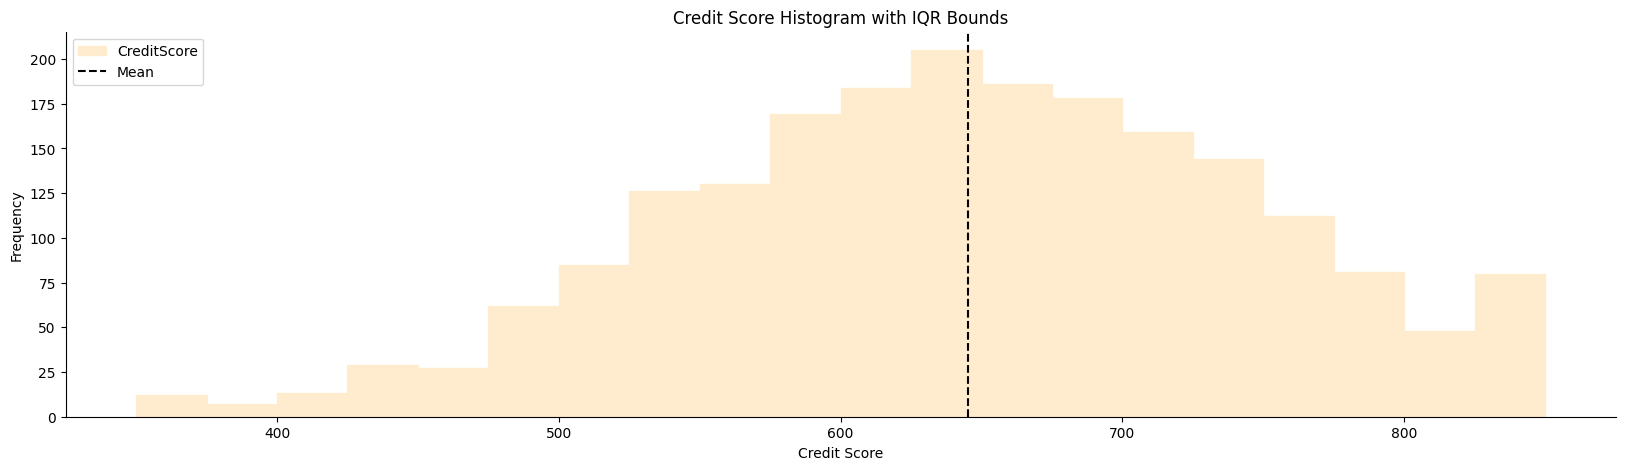

In [14]:
# Plotting the histogram for Credit Score
churned['CreditScore'].plot(kind='hist', bins=20, color='blanchedalmond', edgecolor='blanchedalmond')
Q1 = churned['CreditScore'].quantile(0.25)
Q3 = churned['CreditScore'].quantile(0.75)
mean = churned['CreditScore'].mean()
# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1
plt.axvline(mean, color='black', linestyle='--', label='Mean')
# Formatting the plot
plt.title('Credit Score Histogram with IQR Bounds')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

- Observation:
The histogram of Credit Scores displays a left skew, with a mean value of 650.

- So What?
This left skew indicates that a majority of customers have credit scores below the mean, suggesting a concentration of lower creditworthiness among the customer base.

- Action:
This insight emphasizes the need for tailored financial products or support for customers with lower credit scores. Companies might consider offering educational resources on credit improvement or specific products designed for those with lower credit ratings to enhance customer satisfaction and retention.

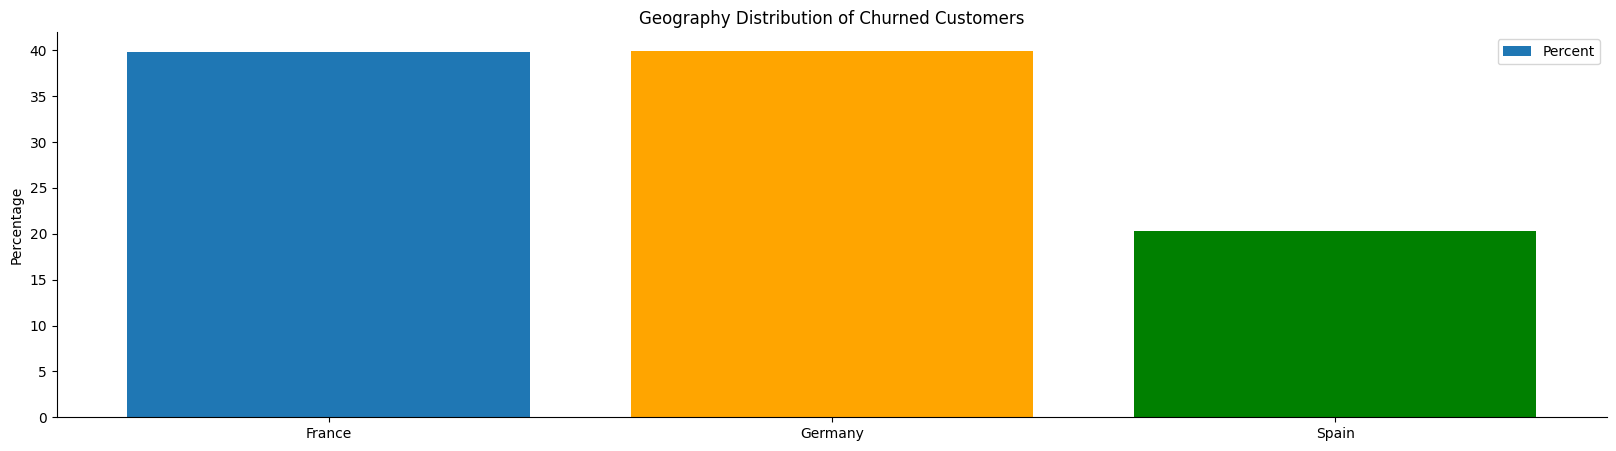

In [17]:
query = '''

select Geography, round(count(*)*1.0/(select count(*) from churn_data where Exited=1)*100,2) as Pct
      from churn_data
where Exited= 1
group by 1
'''
temp = pd.read_sql(query, conn)
colors = ['C0', 'orange', 'green']
plt.bar(temp['Geography'], temp['Pct'], color=colors)
plt.title('Geography Distribution of Churned Customers')
plt.ylabel('Percentage')
plt.legend(['Percent'])
plt.show()

- **Observation:**
France has the highest number of churned customers, followed by Germany and Spain.

- **So What?**
This suggests that customers in France may be more dissatisfied with the products or services compared to other regions, indicating a regional issue affecting customer satisfaction and retention.

- **Action:**
We need to conduct a thorough review of the quality of services and products offered in France, identify pain points, and implement improvements to address customer dissatisfaction and reduce churn in this region.

In [18]:
fr_churned = churned.query('Geography=="France" & Exited==1').reset_index(drop=True)
fr_churned.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScoreCat
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Average
1,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Average
2,15794171,Lombardo,475,France,Female,45,0,134264.04,1,1,0,27822.99,1,Poor
3,15738148,Clarke,465,France,Female,51,8,122522.32,1,0,0,181297.65,1,Poor
4,15755196,Lavine,834,France,Female,49,2,131394.56,1,0,0,194365.76,1,Excellent


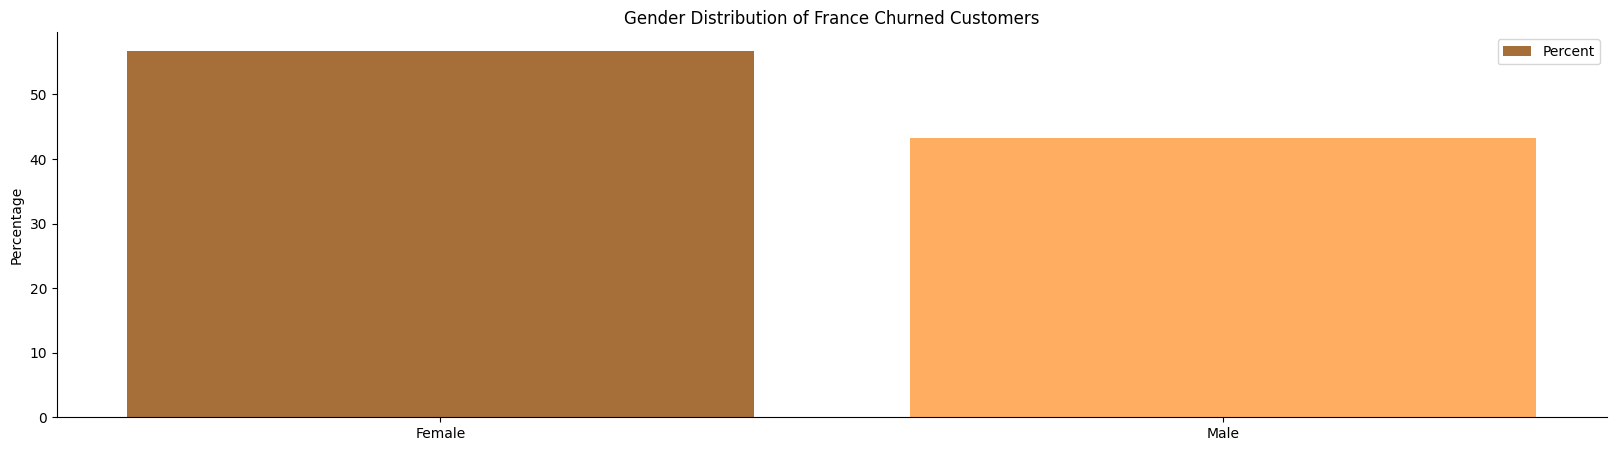

In [19]:
fr_gender = pd.DataFrame(fr_churned['Gender'].value_counts()/len(fr_churned)*100).apply(lambda x : round(x,2)).reset_index()
fr_gender = fr_gender.rename(columns={'count': 'Pct'})
colors = ['#A66E38','#FFAD60']
plt.bar(fr_gender['Gender'], fr_gender['Pct'], color=colors)
plt.title('Gender Distribution of France Churned Customers')
plt.ylabel('Percentage')
plt.legend(['Percent'])
plt.show()

- Observation: French Females gets churned the most meaning females are most dissatisfied customers. 

- So what: It will be worth taking the time to understand what is bothering them in terms of services and products. 

- What to do: A random sample survey can help us determine what those pain points of the female customers could be.

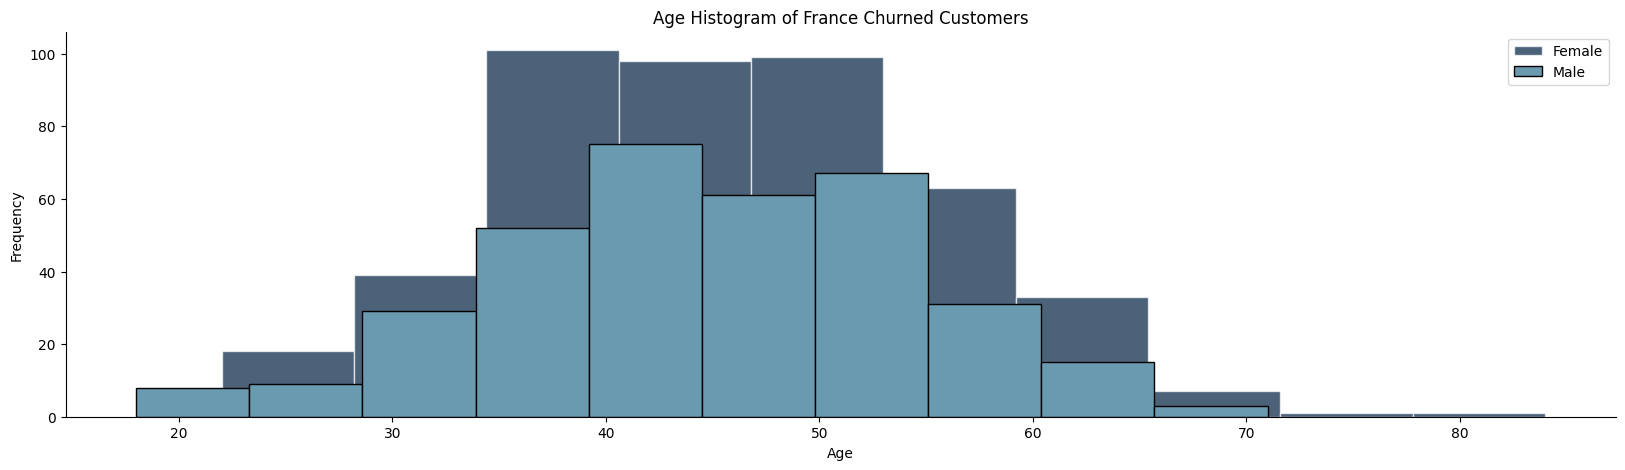

In [20]:
fr_churned.query('Gender=="Female"')['Age'].plot(kind='hist', edgecolor='white', alpha=0.7, color='#001F3F')
fr_churned.query('Gender=="Male"')['Age'].plot(kind='hist', color='#6A9AB0' , edgecolor='black')

plt.title('Age Histogram of France Churned Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(['Female', 'Male'])
plt.show()

- **Finding** In France, Females end up getting churned the most (56%) with an age range of 35 - 55 however in males there is only 43% churn with an age range of 40 to 45.
- **So what?** This suggests that female customers in France, particularly those aged 35-55, are experiencing dissatisfaction with the bank's services or products. 
- **What to do?** Conduct a targeted survey among female customers in France aged 35-55 to understand their specific pain points and identify areas for improvement. This could involve offering tailored products or services, improving communication channels, or addressing specific concerns related to customer service.

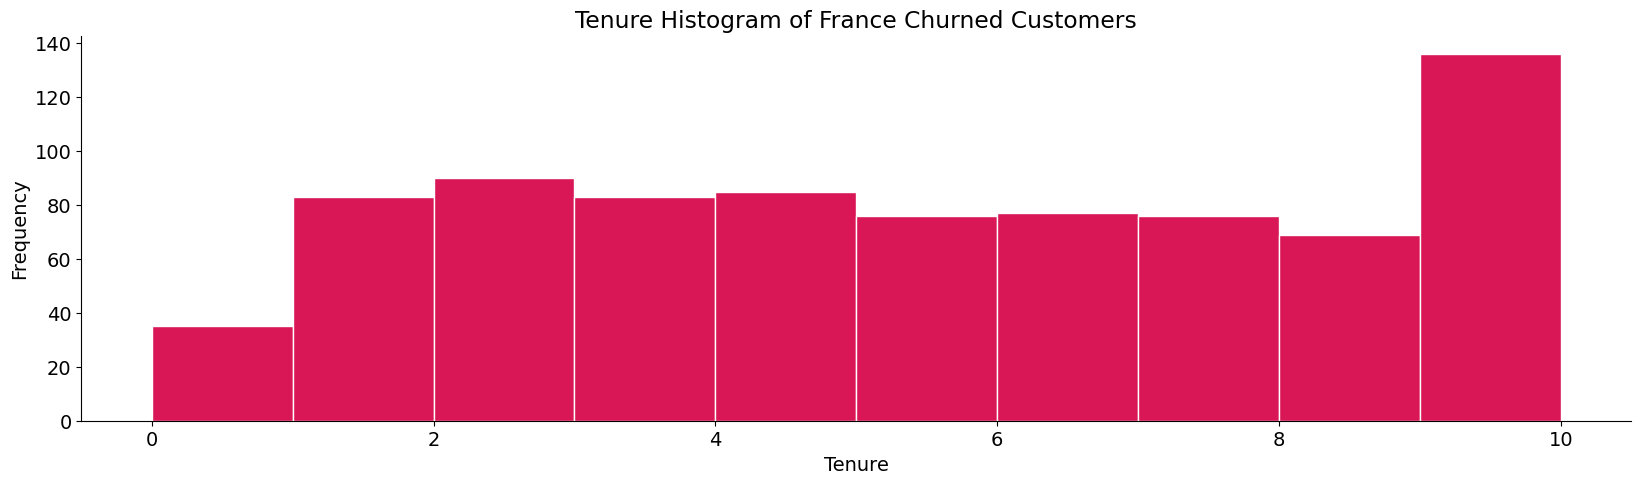

In [23]:
fr_churned['Tenure'].plot(kind='hist', color='#D91656' , edgecolor='white')

plt.title('Tenure Histogram of France Churned Customers')
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.show()

**Observation**:
Customers with a tenure of 9-10 years in France are experiencing the highest churn rates.

**So What?**
This means that long-term customers in France, despite their loyalty, are at a high risk of leaving. This could indicate dissatisfaction with the company’s ability to meet evolving needs, a lack of continued engagement, or inadequate retention strategies targeted at this segment.

**Action**:
We need to conduct a deeper analysis to understand the reasons behind the churn for this group and design targeted retention programs, such as loyalty incentives or personalized offers, to mitigate the churn rate and maintain revenue from these valuable customers.

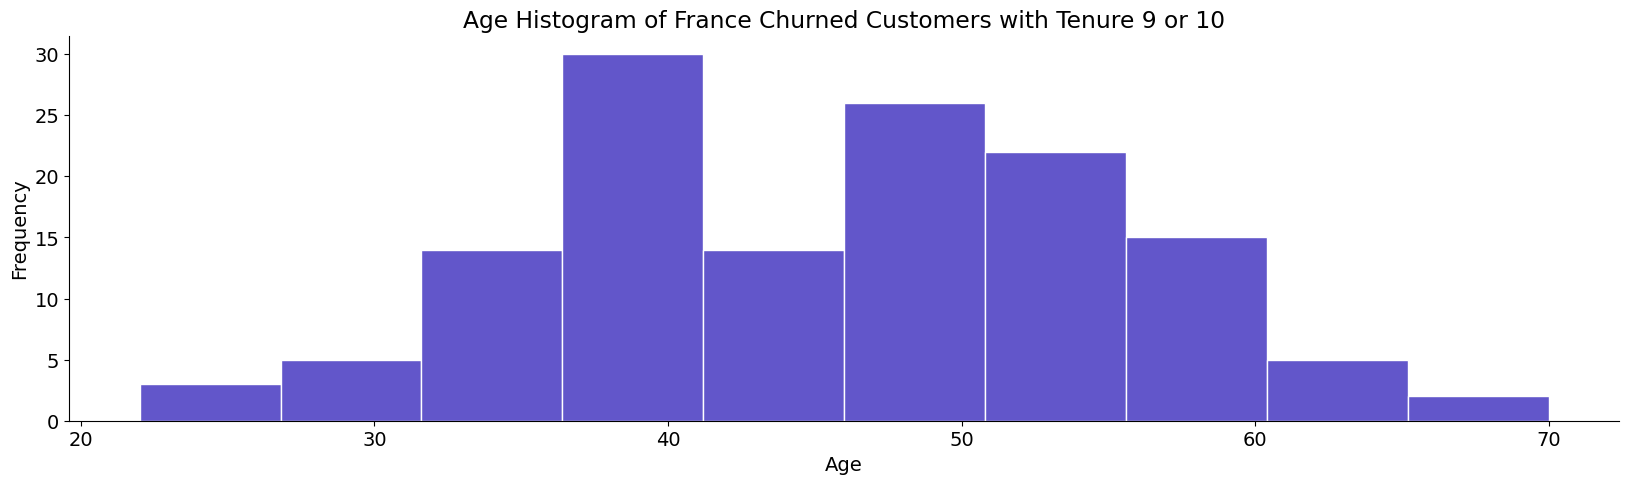

In [24]:
fr_churned.query('Tenure == 9 | Tenure ==10')['Age'].plot(kind='hist', color='#6256CA' , edgecolor='white')

plt.title('Age Histogram of France Churned Customers with Tenure 9 or 10')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

**Observation**:
Multimodal histogram of France churned customers’ age (with tenure of 9 or 10 years) shows peaks at 35-40 and 45-50.

**So What?**
This indicates that customers within these age groups are more likely to churn after 9-10 years of tenure in France. It suggests potential dissatisfaction or unmet needs specifically within middle-aged customer segments. These age groups may have evolving financial or lifestyle requirements that are not being addressed by the current offerings.

**Action**:
We should investigate the specific reasons for churn within these age ranges. Developing age-specific customer engagement or retention strategies, such as personalized services, loyalty programs, or product adjustments, could help reduce churn and improve long-term customer satisfaction and retention for these segments.

In [25]:
fr_cr_score = pd.DataFrame(round(fr_churned.query('Tenure == 9 | Tenure ==10')['CreditScoreCat'].value_counts()/136*100,2))
fr_cr_score = fr_cr_score.rename(columns={'count': 'Pct'}).reset_index()
fr_cr_score

,CreditScoreCat,Pct
0,Average,40.44
1,Good,32.35
2,Excellent,16.91
3,Poor,10.29


- **Observation**:
The majority of France churned customers (with a tenure of 9 or 10 years) have Average (40.44%) or Good (32.35%) credit scores, indicating higher churn risk among typically low-risk customers.

- **So What?**
This suggests that even customers with average or good credit scores, who are usually considered lower risk, are experiencing higher churn. These customers are likely to have been profitable and stable, so losing them poses a significant financial impact. Their churn indicates potential dissatisfaction unrelated to credit risk.

- **Action**:
We should explore the reasons why these financially stable customers are leaving despite their generally good standing. Enhancing customer loyalty programs, offering more competitive benefits, or personalizing engagement efforts for these typically low-risk customers could help mitigate churn and retain this valuable segment.

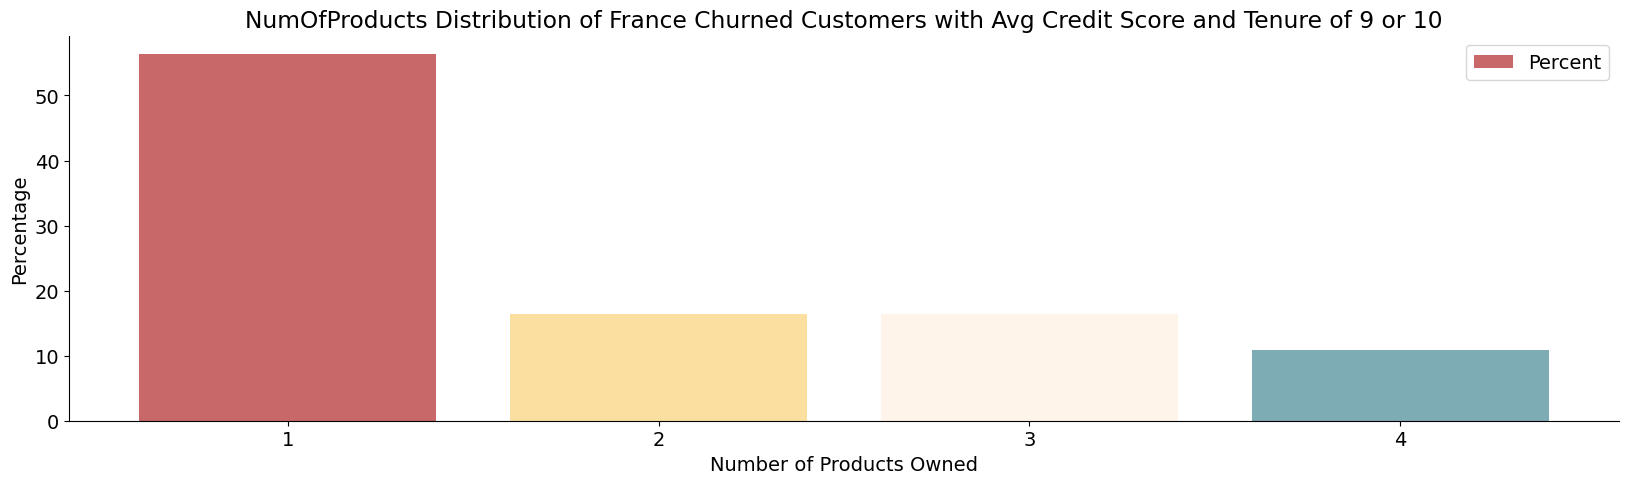

In [26]:
condition1, condition2 = (fr_churned['Tenure'].isin([9,10])), (fr_churned['CreditScoreCat'].isin(['Average', 'Good']))
fr_churned_ten_cat = fr_churned[condition1 & condition2].reset_index(drop=True)
n_rows = fr_churned_ten_cat.query('CreditScoreCat=="Average"').shape[0]
num_prod_df = (fr_churned_ten_cat.query('CreditScoreCat=="Average"')['NumOfProducts'].value_counts()/n_rows*100).to_frame().reset_index()
num_prod_df =  num_prod_df.rename(columns={'count': 'Pct'})
colors = ['#C96868','#FADFA1', '#FFF4EA', '#7EACB5']
plt.bar(num_prod_df['NumOfProducts'], num_prod_df['Pct'], color=colors)
plt.title('NumOfProducts Distribution of France Churned Customers with Avg Credit Score and Tenure of 9 or 10')
plt.ylabel('Percentage')
labels = [1, 2, 3, 4]  
plt.gca().set_xticks(labels)
plt.xlabel('Number of Products Owned')
plt.legend(['Percent'])
plt.show()

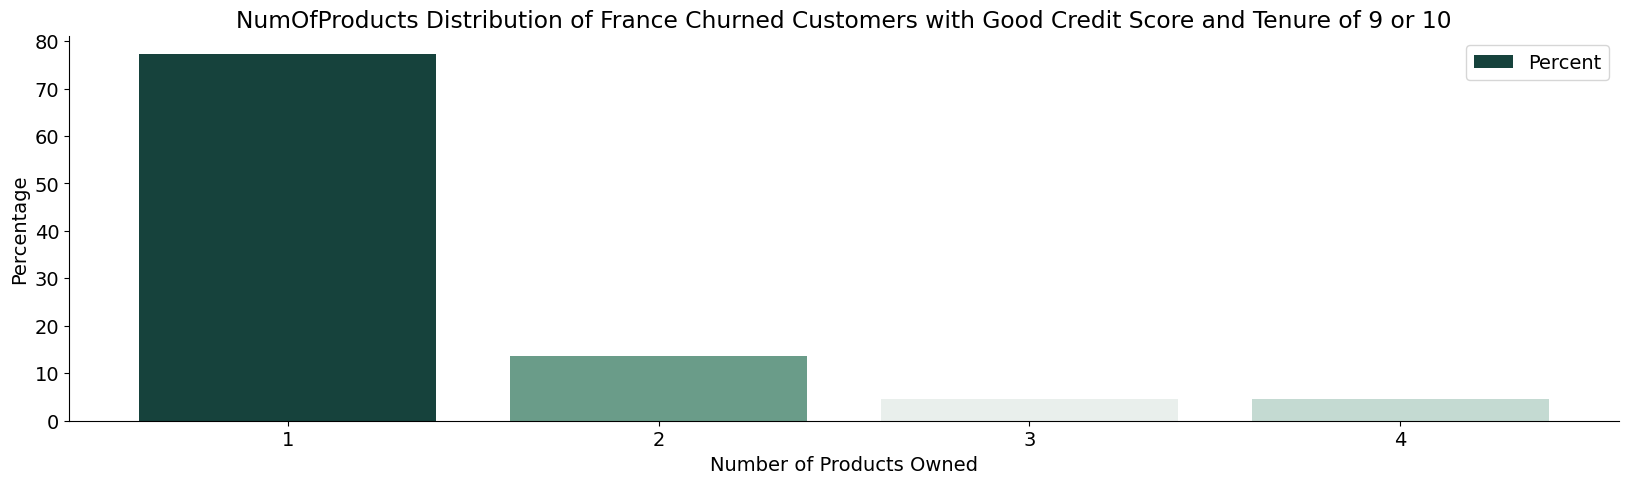

In [27]:
n_rows = fr_churned_ten_cat.query('CreditScoreCat=="Good"').shape[0]
num_prod_df = (fr_churned_ten_cat.query('CreditScoreCat=="Good"')['NumOfProducts'].value_counts()/n_rows*100).to_frame().reset_index()
num_prod_df =  num_prod_df.rename(columns={'count': 'Pct'})
colors = ['#16423C','#6A9C89', '#C4DAD2', '#E9EFEC']
plt.bar(num_prod_df['NumOfProducts'], num_prod_df['Pct'], color=colors)
plt.title('NumOfProducts Distribution of France Churned Customers with Good Credit Score and Tenure of 9 or 10')
plt.ylabel('Percentage')
plt.gca().set_xticks(labels)
plt.xlabel('Number of Products Owned')
plt.legend(['Percent'])
plt.show()

- **Observation**:
The French customer data indicates that a large portion of long-tenured customers (9-10 years) with average or good credit scores and only 1 product are more prone to churn.

- **So What?**
This implies that these customers may be outgrowing the single product they hold, or that the product no longer meets their evolving needs. Despite their long tenure and good financial standing, they may be disengaged due to a lack of product variety or innovation. Losing these customers could point to a gap in product development or customer experience.

- **Action**:
We should consider offering these customers more tailored products or expanding features of the existing product to better match their needs. By improving product diversification and communicating new offerings, we can potentially reduce churn among these high-value, long-term customers and maintain their loyalty.

In [28]:
df.select_dtypes('number').iloc[:, 1:].corr()['Exited'].to_frame()\
        .apply(lambda x : round(x, 2)).reset_index()\
        .rename(columns={'index': 'Column'})

,Column,Exited
0,CreditScore,-0.03
1,Age,0.29
2,Tenure,-0.01
3,Balance,0.12
4,NumOfProducts,-0.05
5,HasCrCard,-0.01
6,IsActiveMember,-0.16
7,EstimatedSalary,0.01
8,Exited,1.00


- **Observation:**
Age and Balance are the most related features to the ‘Exited’ column, while the rest of the columns show weak or negative correlations.

- **So What?**
This indicates that age and balance play a key role in determining whether a customer is likely to churn, while other factors have less predictive value. Focusing on these two features could provide better insights for targeting at-risk customers.

- **Action:**
We should prioritize strategies that address the needs of customers with certain age groups and balance profiles. Tailored retention efforts based on these variables, such as personalized financial advice or balance-related incentives, could reduce churn more effectively than generalized approaches.

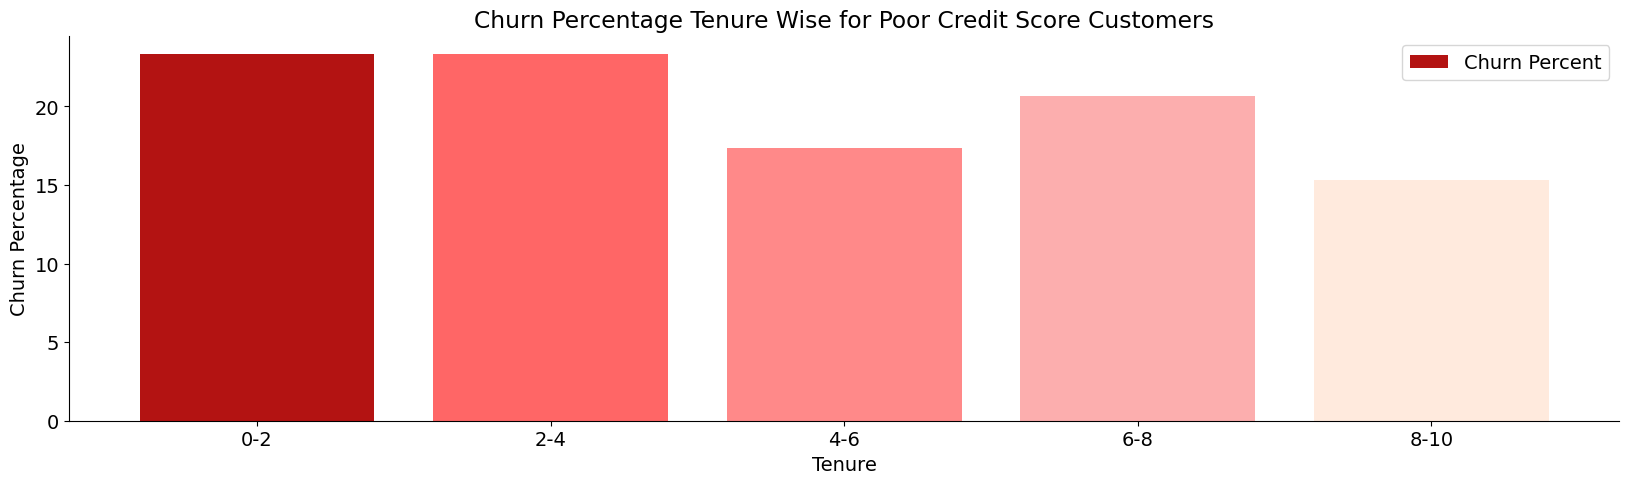

In [29]:
query = '''

with cte as (
select case when Tenure between 0 and 2 then '0-2'
         when Tenure > 2 and Tenure <= 4 then '2-4'
         when Tenure > 4 and Tenure <= 6 then '4-6'
         when Tenure > 6 and Tenure <= 8 then '6-8'
         when Tenure > 8 and Tenure <= 10 then '8-10'
        else '10+' end as Tenure_Cat, HasCrCard
 from churn_data where CreditScoreCat='Poor' and Exited=1)

 select 'Poor' as CreditScore,'Yes' as Exited, Tenure_Cat, sum(HasCrCard) as CardHolders, 
        count(*) as Count ,
        round(count(*)*100.0/ sum( count(*)) over(),2) as Pct
        from cte group by 3
'''
colors = ['#B31312','#FF6666','#FF8989', '#FCAEAE', '#FFEADD']

poor_exited = pd.read_sql(query, conn)
plt.bar(poor_exited['Tenure_Cat'], poor_exited['Pct'], color=colors)
plt.title('Churn Percentage Tenure Wise for Poor Credit Score Customers')
plt.ylabel('Churn Percentage')
plt.xlabel('Tenure')
plt.legend(['Churn Percent'])
plt.show()

- **Observation:**
In the first 4 years, customers with a poor credit score who have exited exhibit a churn rate of 46%, increasing to 63% within the first 6 years.

- **So What?**
This suggests that churn risk is particularly high for customers with poor credit scores in their early years of tenure, with a significant rise after 4 years. Early interventions could be crucial in preventing further churn as tenure increases.

- **Action:**
We should implement targeted retention strategies for customers with poor credit scores during their first few years. Offering tailored financial support or product incentives in years 3-4 could help reduce churn before the critical 6-year mark.

In [30]:
df.pivot_table(index='IsActiveMember', columns='Exited', aggfunc='size', fill_value=0)/len(df)*100

Exited,0,1
IsActiveMember,,
0,35.47,13.02
1,44.16,7.35


- **Observation:**
Inactive members have a higher churn rate of 13%.

- **So What?**
This indicates that inactivity is a strong predictor of churn, and if left unaddressed, it can lead to further customer attrition. Keeping these members engaged is crucial to lowering the churn rate.

- **Action:**
We should introduce engagement strategies, such as personalized offers, targeted promotions, or showcasing new products, to re-engage inactive members. This can help prevent churn and maintain customer loyalty.

## INSIGHTS

- 80% people don't get churned but 20% of the customers do get churned.
- Credit Score shows a left skewed histogram with a mean of 650
- France sees the most churned folks followed by Germany and Spain
- French Females gets churned the most
- Folks with tenure 9-10 get churned the most in France
- In France, Females end up getting churned the most (56%) with an age range of 35 - 55 however in males there is only 43% churn with an age range of 40 to 45.
- France Churned Customer's Age (Tenure 9 or 10) Histogram shows peaks at 35 - 40 and 45- 50
- The majority of France churned customers (with Tenure of 9 or 10 years) have Average (40.44%) or Good (32.35%) credit scores, indicating higher churn risk among typically low-risk customers.
- The French Customers data indicates that a large portion of long-tenured customers (9-10) with an average or good credit score and only 1 product are more prone to churn. This could be because the product is not good enough anymore for them and they maybe need new product or new features in the same product.
- Age and Balance are the most related features to the Exited Column. Rest other columns are weakly or negatively correlated.
- In first 4 years where customer has a poor credit score and has exited, there is a churn rate of 46% and in first 6 years, 63%
- Inactive Member tend to churn out more (13%) so we may want to keep them engaged by some or the other schemes or offers or maybe showing new products.